# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import seaborn as sns
from statsmodels.formula.api import ols

In [2]:
from Functions import get_param_names, get_category_dict, get_ages_cols

## Directories etc.

In [3]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Get data

In [4]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [5]:
param_cols = [c for c in all_data.columns for p in get_param_names() if p in c]
ages_cols = get_ages_cols()
category_dict = get_category_dict()

## Correlation between features

In [6]:
x_ticks = []
vlines = []
new_line = 0
for cols in category_dict.values():
    x_ticks += cols
    new_line += len(cols)
    vlines += [new_line]

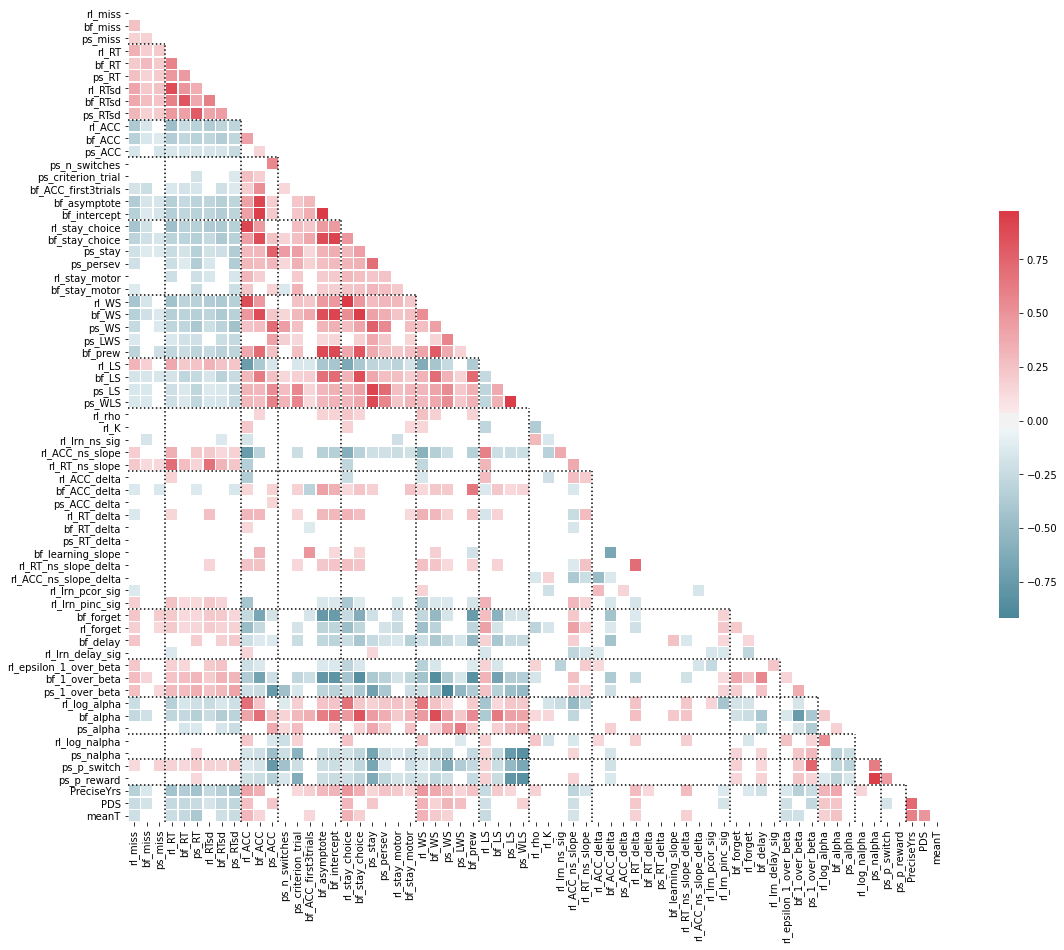

In [7]:
# Compute the correlation matrix
crit_p = 0.05
sub_dat = all_data[x_ticks + ['PreciseYrs', 'PDS', 'meanT']]
spearman = scipy.stats.spearmanr(sub_dat, nan_policy='omit')
corr = spearman.correlation
corr = pd.DataFrame(corr, columns=sub_dat.columns, index=sub_dat.columns)

# Generate a mask for the upper triangle
triangle_mask = np.triu(np.ones_like(corr, dtype=np.bool))
sig_mask = spearman.pvalue < crit_p
mask = np.invert(sig_mask * np.invert(triangle_mask))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.hlines(y=vlines, xmin=0, xmax=vlines, linestyle='dotted')
ax.vlines(x=vlines, ymin=ax.get_ylim()[0], ymax=vlines, linestyle='dotted')
plt.savefig(os.path.join(plot_save_path, '2_CorrMatrix.png'))

In [8]:
# Same for age-cleaned residuals
all_data['PreciseYrs2'] = np.square(all_data['PreciseYrs'])
ages_cols += ['PreciseYrs2']
resid_dat = pd.DataFrame()

for outcome in [c for c in sub_dat.columns.values if not c in ages_cols]:
    
    # Run regression
    formula = '{} ~ PreciseYrs + PreciseYrs2'.format(outcome)
    fit = ols(data=all_data, formula=formula).fit()

    # Get residuals
    resid_row = pd.DataFrame(fit.resid).T
    resid_row.index = ['resid_{}'.format(outcome)]

    resid_dat = resid_dat.append(resid_row)

resid_dat = resid_dat.T
resid_dat

,resid_rl_miss,resid_bf_miss,resid_ps_miss,resid_rl_RT,resid_bf_RT,resid_ps_RT,resid_rl_RTsd,resid_bf_RTsd,resid_ps_RTsd,resid_rl_ACC,...,resid_rl_epsilon_1_over_beta,resid_bf_1_over_beta,resid_ps_1_over_beta,resid_rl_log_alpha,resid_bf_alpha,resid_ps_alpha,resid_rl_log_nalpha,resid_ps_nalpha,resid_ps_p_switch,resid_ps_p_reward
0,-0.000651,-0.015932,0.003753,0.160540,-0.135320,0.081130,0.221012,-0.235502,0.001172,0.083125,...,0.004200,0.001971,0.212879,0.538480,0.003977,0.023141,0.443312,0.154517,0.052926,0.049902
1,-0.002147,-0.007353,-0.001073,-0.121527,-0.100113,0.093777,-0.159208,-0.199361,0.041850,0.066750,...,0.000190,-0.003070,-0.064341,-0.062236,-0.017156,-0.098099,1.112951,-0.129774,-0.034073,-0.068710
2,-0.001171,-0.004271,-0.000578,-0.165135,-0.231477,-0.137056,-0.191062,-0.138209,-0.140127,0.096858,...,-0.026549,-0.005826,-0.221293,-0.251151,0.001528,0.091955,1.617795,-0.042832,-0.073920,0.024186
3,-0.000412,-0.001807,-0.000246,0.101444,0.351712,0.049250,0.119488,0.429730,0.025119,-0.026517,...,0.017005,0.006219,0.204720,-0.469260,-0.055374,0.049721,1.576274,-0.043188,0.031393,-0.028071
4,-0.003031,-0.010105,-0.001558,-0.057454,0.270119,0.016600,0.023049,0.063945,-0.018863,0.126273,...,-0.028534,0.015727,0.059822,0.131719,0.070377,0.100756,-0.152471,0.136346,0.021604,0.056722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.000432,0.001433,-0.000317,-0.100733,0.048911,0.156353,-0.149895,-0.007106,0.093357,-0.006100,...,0.016999,0.010031,-0.089904,0.058464,-0.100080,0.024035,2.135618,0.013019,-0.013826,0.009040
243,0.000362,0.000923,-0.000101,-0.074491,-0.216063,-0.143204,-0.050092,-0.219320,-0.084324,0.022922,...,0.003471,0.003144,-0.137161,2.778221,0.082739,0.098162,4.434147,-0.060219,-0.052932,0.025075
244,0.000170,0.000185,-0.000084,0.166027,0.177235,0.180497,0.376619,0.274061,0.127631,0.039043,...,0.012395,0.006697,-0.044790,-0.690674,-0.039573,-0.007877,1.392543,0.165336,0.015267,0.070989
245,0.002581,0.001400,0.006162,0.075097,1.055248,0.087472,0.196937,1.006676,0.024090,-0.017155,...,0.057531,0.004322,-0.015122,3.284818,-0.014412,0.029650,-8.271041,0.037524,0.053221,0.037716


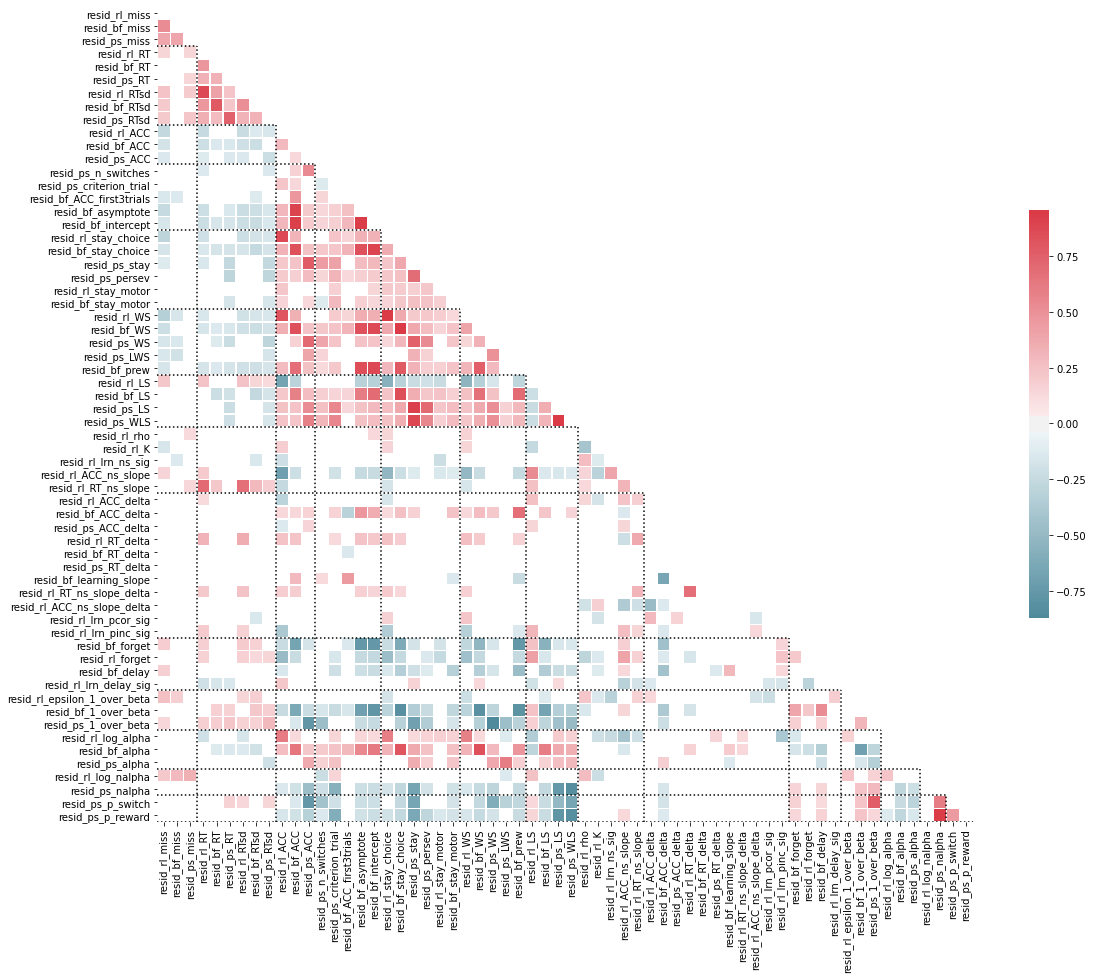

In [9]:
spearman_resid = scipy.stats.spearmanr(resid_dat, nan_policy='omit')
resid_corr = spearman_resid.correlation
resid_corr = pd.DataFrame(resid_corr, columns=resid_dat.columns, index=resid_dat.columns)

# Generate a resid_mask for the upper triangle
triangle_resid_mask = np.triu(np.ones_like(resid_corr, dtype=np.bool))
sig_resid_mask = spearman_resid.pvalue < crit_p
resid_mask = np.invert(sig_resid_mask * np.invert(triangle_resid_mask))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the resid_mask and resid_correct aspect ratio
ax = sns.heatmap(resid_corr, mask=resid_mask, cmap=cmap, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.hlines(y=vlines, xmin=0, xmax=vlines, linestyle='dotted')
ax.vlines(x=vlines, ymin=ax.get_ylim()[0], ymax=vlines, linestyle='dotted')
plt.savefig(os.path.join(plot_save_path, '2_Residresid_corrMatrix.png'))

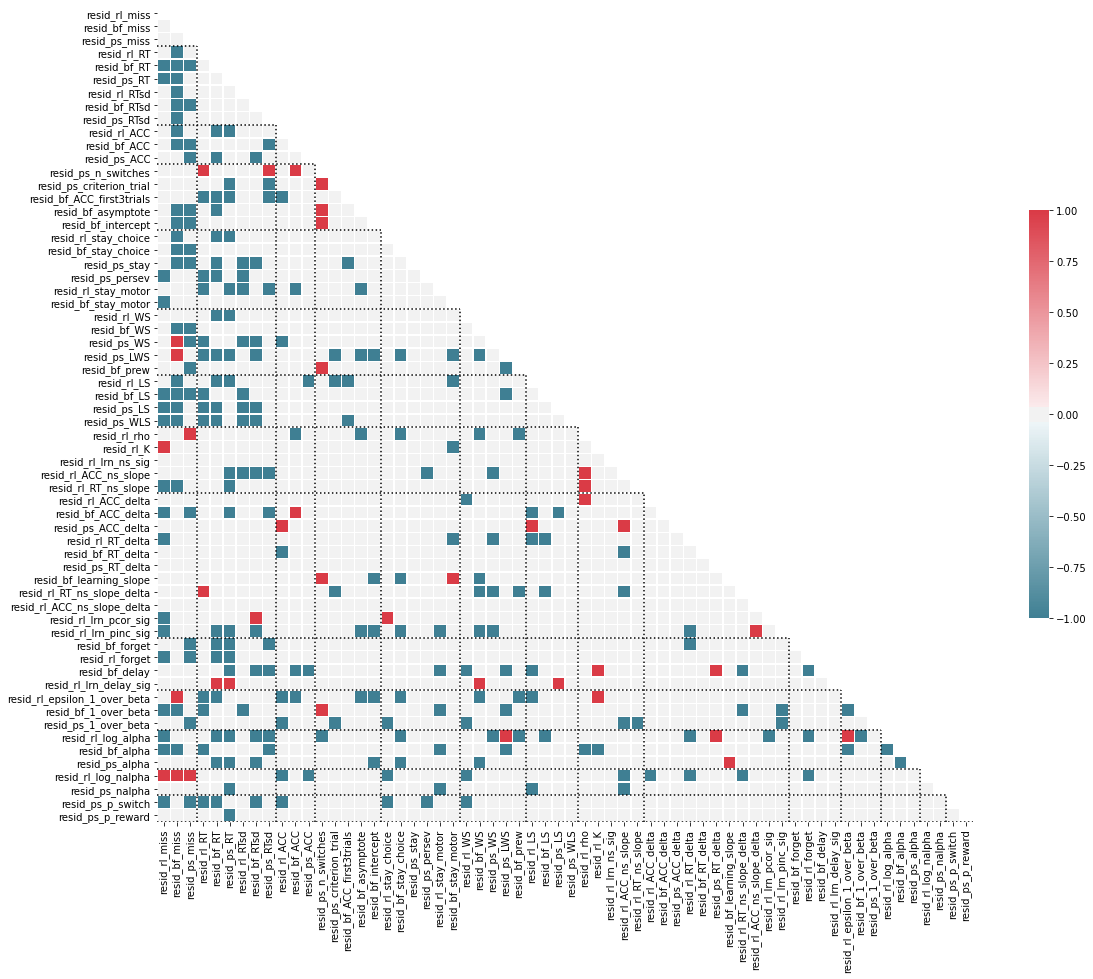

In [13]:
# Difference between raw data and diffuals
diff = pd.DataFrame(mask[:resid_mask.shape[0], :resid_mask.shape[1]].astype(int) - resid_mask.astype(int),
                    dtype=float,  # if datatype is not float, heatmap doesn't work
                    index=resid_corr.columns, columns=resid_corr.columns)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot
ax = sns.heatmap(diff, mask=triangle_resid_mask, cmap=cmap, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.hlines(y=vlines, xmin=0, xmax=vlines, linestyle='dotted')
ax.vlines(x=vlines, ymin=ax.get_ylim()[0], ymax=vlines, linestyle='dotted')
plt.savefig(os.path.join(plot_save_path, '2_DiffMatrix.png'))

# OLD

In [ ]:
# # Correlations between ACCs and RTs in different tasks
# rt_cols = [col for col in all_data.columns if
#            ('RT' in col) and ('sd' not in col) and ('delta' not in col) and ('minus' not in col)]
# rtsd_cols = [col for col in all_data.columns if 'RTsd' in col]
# acc_cols = [col for col in all_data.columns if
#             ('ACC' in col) and ('delta' not in col) and ('minus' not in col)]

# # Compute the correlation matrix
# dat = all_data[acc_cols + rt_cols + rtsd_cols + ['PreciseYrs']]
# corr = scipy.stats.spearmanr(dat, nan_policy='omit').correlation
# corr = pd.DataFrame(corr, columns=dat.columns, index=dat.columns)

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(20, 15))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.savefig(os.path.join(plot_save_path, '2_CorrMatrixAccRt.png'))

In [ ]:
# # Correlations between parameters in different tasks
# param_cols_by_param = [
#     p for p in param_cols if 'beta' in p] + [
#     p for p in param_cols if 'alpha' in p] + [
#     p for p in param_cols if 'persev' in p] + [
#     p for p in param_cols if 'forget' in p] + [
#     p for p in param_cols if ('beta' not in p) and ('alpha' not in p) and ('persev' not in p) and ('forget' not in p)
# ]

# # Compute the correlation matrix
# dat = all_data[param_cols_by_param + ['PreciseYrs']]
# corr = scipy.stats.spearmanr(dat, nan_policy='omit').correlation
# corr = pd.DataFrame(corr, columns=dat.columns, index=dat.columns)

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(20, 15))

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1, vmin=-1,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# plt.savefig(os.path.join(plot_save_path, '2_CorrMatrixPar.png'))